# Explore DRAPER Satellite Image Data

#### Author: Manasa Raghavan

## Problem Statement

Training data folder consists of satellite images daily taken from day one to day five. Test data folder consists of five sets of random images of the same place. The model has to use the train data and learn the pattern of images taken daily, and arrange the images of each set in the test folder.

This notebook will go through some exploratory analysis of the images in the training dataset.

In [68]:
import cv2
import numpy as np
import sys

from skimage.data import camera
from skimage import feature
from skimage.filters import roberts, sobel, scharr, prewitt

from scipy import ndimage as ndi

import matplotlib.pyplot as plt
%matplotlib inline

import glob, os

In [69]:

smjpegs = [f for f in glob.glob("input/train_sm/*.jpeg")]
print(smjpegs[:9])

['input/train_sm\\set107_1.jpeg', 'input/train_sm\\set107_2.jpeg', 'input/train_sm\\set107_3.jpeg', 'input/train_sm\\set107_4.jpeg', 'input/train_sm\\set107_5.jpeg', 'input/train_sm\\set10_1.jpeg', 'input/train_sm\\set10_2.jpeg', 'input/train_sm\\set10_3.jpeg', 'input/train_sm\\set10_4.jpeg']


In [71]:
set4 = [smj for smj in smjpegs if "set4_" in smj]
print (set4)

['input/train_sm\\set4_1.jpeg', 'input/train_sm\\set4_2.jpeg', 'input/train_sm\\set4_3.jpeg', 'input/train_sm\\set4_4.jpeg', 'input/train_sm\\set4_5.jpeg']


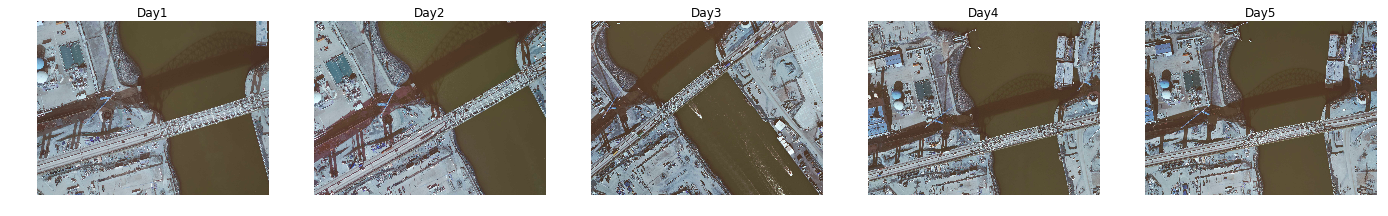

In [72]:
# image =  cv2.imread(set4[0],1)
fig = plt.figure(figsize=(24, 9))
# ax1 = plt.subplot(1, 5, 1)
# ax1.imshow(image)
# ax1.set_axis_off()
# ax1.set_title('Day1')

# ax1 = plt.subplot(1, 5, 2)
# ax1.imshow(image)
# ax1.set_axis_off()
# ax1.set_title('Day1')
# ax2 = plt.subplot(1, 5, 2, sharex=ax1, sharey=ax1, adjustable='box-forced')
# ax3 = plt.subplot(1, 5, 3)
for n in range(0,5):
    image = cv2.imread(set4[n],1)
    ax = plt.subplot(1,5,n+1)
    ax.imshow(image)
    ax.set_axis_off()
    tStr = 'Day'+str(n+1)
    ax.set_title(tStr)


In [73]:
image_d1 = cv2.imread(set4[0],1)
image_d2 = cv2.imread(set4[1],1)
image_d3 = cv2.imread(set4[2],1)
image_d4 = cv2.imread(set4[3],1)
image_d5 = cv2.imread(set4[4],1)

In [74]:
from skimage.transform import rotate

In [75]:
image_d5.shape

(2329L, 3099L, 3L)

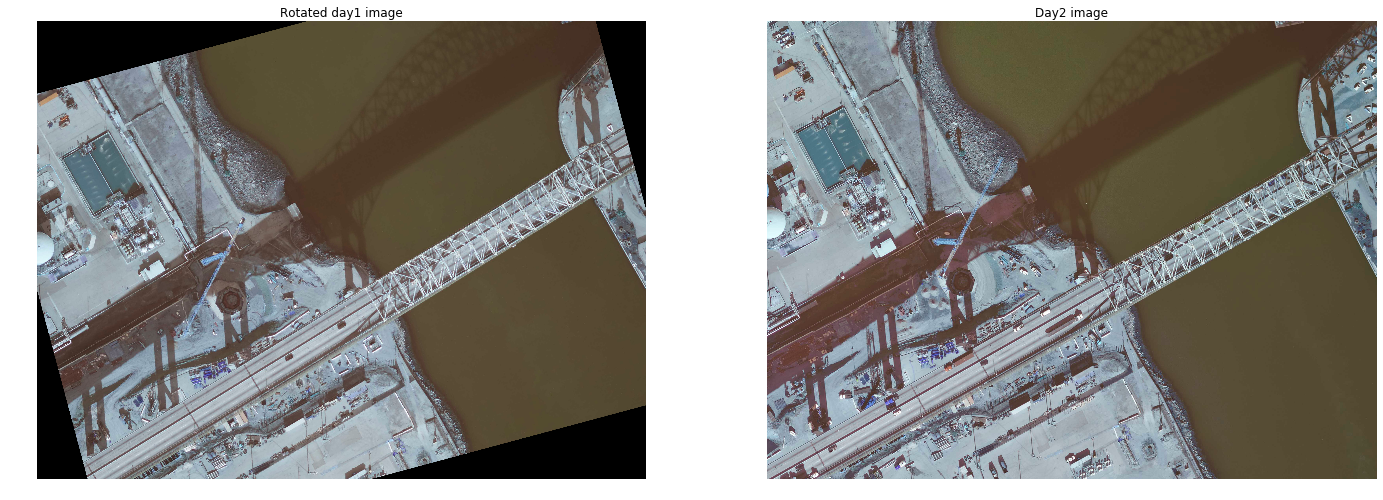

In [76]:
fig = plt.figure(figsize=(24, 9))
image_d1_rot = rotate(image_d1, angle=15, order=0)

ax1 = plt.subplot(1,2,1)
ax1.imshow(image_d1_rot)
ax1.set_axis_off()
ax1.set_title('Rotated day1 image')

ax2 = plt.subplot(1,2,2)
ax2.imshow(image_d2)
ax2.set_axis_off()
ax2.set_title('Day2 image')

This code was obtained from here http://www.lfd.uci.edu/~gohlke/code/imreg.py.html

In [77]:
# -*- coding: utf-8 -*-
# imreg.py

# Copyright (c) 2011-2014, Christoph Gohlke
# Copyright (c) 2011-2014, The Regents of the University of California
# Produced at the Laboratory for Fluorescence Dynamics
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# * Redistributions of source code must retain the above copyright
#   notice, this list of conditions and the following disclaimer.
# * Redistributions in binary form must reproduce the above copyright
#   notice, this list of conditions and the following disclaimer in the
#   documentation and/or other materials provided with the distribution.
# * Neither the name of the copyright holders nor the names of any
#   contributors may be used to endorse or promote products derived
#   from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED.  IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

"""FFT based image registration.

Implements an FFT-based technique for translation, rotation and scale-invariant
image registration [1].

:Author:
  `Christoph Gohlke <http://www.lfd.uci.edu/~gohlke/>`_

:Organization:
  Laboratory for Fluorescence Dynamics, University of California, Irvine

:Version: 2013.01.18

Requirements
------------
* `CPython 2.7 or 3.3 <http://www.python.org>`_
* `Numpy 1.7 <http://www.numpy.org>`_
* `Scipy 0.12 <http://www.scipy.org>`_
* `Matplotlib 1.2 <http://www.matplotlib.org>`_  (optional for plotting)

Notes
-----
The API and algorithms are not stable yet and are expected to change between
revisions.

References
----------
(1) An FFT-based technique for translation, rotation and scale-invariant
    image registration. BS Reddy, BN Chatterji.
    IEEE Transactions on Image Processing, 5, 1266-1271, 1996
(2) An IDL/ENVI implementation of the FFT-based algorithm for automatic
    image registration. H Xiea, N Hicksa, GR Kellera, H Huangb, V Kreinovich.
    Computers & Geosciences, 29, 1045-1055, 2003.
(3) Image Registration Using Adaptive Polar Transform. R Matungka, YF Zheng,
    RL Ewing. IEEE Transactions on Image Processing, 18(10), 2009.

Examples
--------
>>> im0 = imread('t400')
>>> im1 = imread('Tr19s1.3')
>>> im2, scale, angle, (t0, t1) = similarity(im0, im1)
>>> imshow(im0, im1, im2)

>>> im0 = imread('t350380ori')
>>> im1 = imread('t350380shf')
>>> t0, t1 = translation(im0, im1)

"""

from __future__ import division, print_function

import math

import numpy
from numpy.fft import fft2, ifft2, fftshift

try:
    import scipy.ndimage.interpolation as ndii
except ImportError:
    import ndimage.interpolation as ndii

__version__ = '2013.01.18'
__docformat__ = 'restructuredtext en'
__all__ = ['translation', 'similarity']


def translation(im0, im1):
    """Return translation vector to register images."""
    shape = im0.shape
    f0 = fft2(im0)
    f1 = fft2(im1)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = numpy.unravel_index(numpy.argmax(ir), shape)
    if t0 > shape[0] // 2:
        t0 -= shape[0]
    if t1 > shape[1] // 2:
        t1 -= shape[1]
    return [t0, t1]


def similarity(im0, im1):
    """Return similarity transformed image im1 and transformation parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector.

    A similarity transformation is an affine transformation with isotropic
    scale and without shear.

    Limitations:
    Image shapes must be equal and square.
    All image areas must have same scale, rotation, and shift.
    Scale change must be less than 1.8.
    No subpixel precision.

    """
    if im0.shape != im1.shape:
        raise ValueError("Images must have same shapes.")
    elif len(im0.shape) != 2:
        raise ValueError("Images must be 2 dimensional.")

    f0 = fftshift(abs(fft2(im0)))
    f1 = fftshift(abs(fft2(im1)))

    h = highpass(f0.shape)
    f0 *= h
    f1 *= h
    del h

    f0, log_base = logpolar(f0)
    f1, log_base = logpolar(f1)

    f0 = fft2(f0)
    f1 = fft2(f1)
    r0 = abs(f0) * abs(f1)
    ir = abs(ifft2((f0 * f1.conjugate()) / r0))
    i0, i1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)
    angle = 180.0 * i0 / ir.shape[0]
    scale = log_base ** i1

    if scale > 1.8:
        ir = abs(ifft2((f1 * f0.conjugate()) / r0))
        i0, i1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)
        angle = -180.0 * i0 / ir.shape[0]
        scale = 1.0 / (log_base ** i1)
        if scale > 1.8:
            raise ValueError("Images are not compatible. Scale change > 1.8")

    if angle < -90.0:
        angle += 180.0
    elif angle > 90.0:
        angle -= 180.0

    im2 = ndii.zoom(im1, 1.0/scale)
    im2 = ndii.rotate(im2, angle)

    if im2.shape < im0.shape:
        t = numpy.zeros_like(im0)
        t[:im2.shape[0], :im2.shape[1]] = im2
        im2 = t
    elif im2.shape > im0.shape:
        im2 = im2[:im0.shape[0], :im0.shape[1]]

    f0 = fft2(im0)
    f1 = fft2(im2)
    ir = abs(ifft2((f0 * f1.conjugate()) / (abs(f0) * abs(f1))))
    t0, t1 = numpy.unravel_index(numpy.argmax(ir), ir.shape)

    if t0 > f0.shape[0] // 2:
        t0 -= f0.shape[0]
    if t1 > f0.shape[1] // 2:
        t1 -= f0.shape[1]

    im2 = ndii.shift(im2, [t0, t1])

    # correct parameters for ndimage's internal processing
    if angle > 0.0:
        d = int((int(im1.shape[1] / scale) * math.sin(math.radians(angle))))
        t0, t1 = t1, d+t0
    elif angle < 0.0:
        d = int((int(im1.shape[0] / scale) * math.sin(math.radians(angle))))
        t0, t1 = d+t1, d+t0
    scale = (im1.shape[1] - 1) / (int(im1.shape[1] / scale) - 1)

    return im2, scale, angle, [-t0, -t1]


def similarity_matrix(scale, angle, vector):
    """Return homogeneous transformation matrix from similarity parameters.

    Transformation parameters are: isotropic scale factor, rotation angle (in
    degrees), and translation vector (of size 2).

    The order of transformations is: scale, rotate, translate.

    """
    S = numpy.diag([scale, scale, 1.0])
    R = numpy.identity(3)
    angle = math.radians(angle)
    R[0, 0] = math.cos(angle)
    R[1, 1] = math.cos(angle)
    R[0, 1] = -math.sin(angle)
    R[1, 0] = math.sin(angle)
    T = numpy.identity(3)
    T[:2, 2] = vector
    return numpy.dot(T, numpy.dot(R, S))


def logpolar(image, angles=None, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = numpy.empty((angles, radii), dtype=numpy.float64)
    theta.T[:] = -numpy.linspace(0, numpy.pi, angles, endpoint=False)
    #d = radii
    d = numpy.hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (math.log10(d) / (radii))
    radius = numpy.empty_like(theta)
    radius[:] = numpy.power(log_base, numpy.arange(radii,
                                                   dtype=numpy.float64)) - 1.0
    x = radius * numpy.sin(theta) + center[0]
    y = radius * numpy.cos(theta) + center[1]
    output = numpy.empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output, log_base


def highpass(shape):
    """Return highpass filter to be multiplied with fourier transform."""
    x = numpy.outer(
        numpy.cos(numpy.linspace(-math.pi/2., math.pi/2., shape[0])),
        numpy.cos(numpy.linspace(-math.pi/2., math.pi/2., shape[1])))
    return (1.0 - x) * (2.0 - x)


def imread(fname, norm=True):
    """Return image data from img&hdr uint8 files."""
    with open(fname+'.hdr', 'r') as fh:
        hdr = fh.readlines()
    img = numpy.fromfile(fname+'.img', numpy.uint8, -1)
    img.shape = int(hdr[4].split()[-1]), int(hdr[3].split()[-1])
    if norm:
        img = img.astype(numpy.float64)
        img /= 255.0
    return img


def imshow(im0, im1, im2, im3=None, cmap=None, **kwargs):
    """Plot images using matplotlib."""
    from matplotlib import pyplot
    if cmap is None:
        cmap = 'coolwarm'
    if im3 is None:
        im3 = abs(im2 - im0)
    pyplot.subplot(221)
    pyplot.imshow(im0, cmap, **kwargs)
    pyplot.subplot(222)
    pyplot.imshow(im1, cmap, **kwargs)
    pyplot.subplot(223)
    pyplot.imshow(im3, cmap, **kwargs)
    pyplot.subplot(224)
    pyplot.imshow(im2, cmap, **kwargs)
    pyplot.show()

In [78]:
img2_t, scale, angle, (t0, t1) = similarity(image_d1_rot[:,:,2] ,image_d2[:,:,2])
print (scale, angle, t0, t1)

1.0 0.0 0 560


In [79]:
img2_t, scale, angle, (t0, t1) = similarity(image_d1[:,:,2],image_d2[:,:,2])

In [80]:
print (scale, angle, t0, t1)

1.0 0.0 -67 0


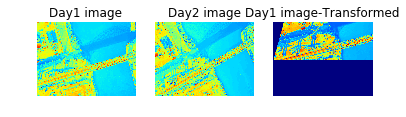

In [90]:
ax1 = plt.subplot(1,3,1)
ax1.imshow(image_d1[:,:,0])
ax1.set_axis_off()
ax1.set_title('Day1 image')

ax2 = plt.subplot(1,3,2)
ax2.imshow(image_d2[:,:,0])
ax2.set_axis_off()
ax2.set_title('Day2 image')


ax3 = plt.subplot(1,3,3)
ax3.imshow(img1_t)
ax3.set_axis_off()
ax3.set_title('Day1 image-Transformed')

In [85]:
img1_t, scale, angle, (t0, t1) = similarity(image_d1[:,:,0],image_d2[:,:,0])
print (scale, angle, t0, t1)


0.943074581431 -15.4572778016 658 -171


In [86]:
img1_t, scale, angle, (t0, t1) = similarity(image_d1[:,:,1],image_d2[:,:,1])
print (scale, angle, t0, t1)


0.95001533272 -15.4572778016 653 1765


In [82]:
img2_t, scale, angle, (t0, t1) = similarity(image_d2[:,:,2],image_d3[:,:,2])
print (scale, angle, t0, t1)


1.0 0.0772863890082 0 -429


In [87]:
img2_t, scale, angle, (t0, t1) = similarity(image_d2[:,:,0],image_d3[:,:,0])
print (scale, angle, t0, t1)

1.0 0.0 -1081 208


In [91]:
img2_t, scale, angle, (t0, t1) = similarity(image_d3[:,:,0],image_d2[:,:,0])
print (scale, angle, t0, t1)

1.0 0.0 1081 -208


In [88]:
img2_t, scale, angle, (t0, t1) = similarity(image_d2[:,:,1],image_d3[:,:,1])
print (scale, angle, t0, t1)

1.0 0.0 381 0


In [92]:
img2_t, scale, angle, (t0, t1) = similarity(image_d3[:,:,1],image_d2[:,:,1])
print (scale, angle, t0, t1)

1.0 0.0 -381 0


In [83]:
img3_t, scale, angle, (t0, t1) = similarity(image_d3[:,:,2],image_d4[:,:,2])
print (scale, angle, t0, t1)


1.0 0.0 1008 0


In [84]:
img4_t, scale, angle, (t0, t1) = similarity(image_d4[:,:,2],image_d5[:,:,2])
print (scale, angle, t0, t1)

1.01241830065 3.70974667239 -68 -194


In [93]:
from skimage import transform as tf

In [95]:
tform = tf.estimate_transform('similarity', image_d1[:,:,0], image_d2[:,:,0])

ValueError: shapes (3,3) and (3100,2329) not aligned: 3 (dim 1) != 3100 (dim 0)

In [ ]:
type(tform)